# Architecture-dependent physical costs

While Qualtran provides tooling for expressing and reasoning about quantum algorithms, a
particularly compelling use case for such a software tool is to provide estimates of resource
requirements for quantum algorithms that could be executed on a future quantum computer. In
particular, we’re interested in resource estimates compatible with the hardware roadmaps of quantum
hardware providers. 

A complete quantum computing system will be built with layers of abstraction
Algorithms expressed as Qualtran bloqs are encoded at the
architecture-agnostic level "application" and "logical" levels of abstraction. We anticipate that
future tools or interoperability software will consume the output of a full decomposition of a
Qualtran program and explicitly compile it to a specific error-corrected architecture or platform.

In lieu of the existence of such tools, we provide access to common literature models for converting
"logical costs" to "physical costs". We define these terms: logical costs are hardware
architecture-agnostic properties of an algorithm that we desire to minimize. Common logical costs
are the number of (logical) qubits or the number of (logical) gates. Physical costs are those that
matter in the physical world, such as the number of physical qubits (e.g. individual transmons or
trapped ions) and the wall-clock time required to physically execute an algorithm.

## `PhysicalCostModel`

We contain all the components for doing an estimation of physical costs within the
`qualtran.surface_code.PhysicalCostModel` class.
The model is parameterized by 1) properties of the target hardware architecture and 2) Execution protocol design choices.
We further factor the design choices into a) the data block design for storing
algorithm qubits, b) the magic state factory construction, and c) the error suppression
ability of the code. In total, the model is composed of

 - `physical_params: PhysicalParameters`
 - `data_block: DataBlock`
 - `factory: MagicStateFactory`
 - `qec_scheme: QECScheme`

Each method for computing physical costs take algorithmcounts inputs: the number of
algorithm qubits and the number of algorithm gates. Output quantities
include the wall-clock time, the number of physical qubits, and the probability of failure
due to the physical realization of the algorithm.

In [1]:
from qualtran.surface_code import AlgorithmSummary
from qualtran.resource_counting import GateCounts

# Set up some example parameters
alg = AlgorithmSummary(
    n_algo_qubits=100,
    n_logical_gates=GateCounts(toffoli=1e8),
)

In [2]:
from qualtran.surface_code import PhysicalCostModel

# For minimal configuration, you can use a set of defaults from
# the literature. Here: Gidney and Fowler (2018).
cost_model = PhysicalCostModel.make_gidney_fowler(data_d=25)

print(
    f'Duration {cost_model.duration_hr(alg):.2f} hr',
    f'\nPhysical Qubits {cost_model.n_phys_qubits(alg):,d}',
    f'\nError {cost_model.error(alg):.2g}'
)

Duration 4.74 hr 
Physical Qubits 335,404 
Error 0.031


In [3]:
# Compare with the defaults based on another set of literature-based defaults
cost_model_2 = PhysicalCostModel.make_beverland_et_al(data_d=25)

print(
    f'Duration {cost_model_2.duration_hr(alg):.2f} hr',
    f'\nPhysical Qubits {cost_model_2.n_phys_qubits(alg):,d}',
    f'\nError {cost_model_2.error(alg):.2g}'
)

Duration 2.50 hr 
Physical Qubits 188,646 
Error 8.1e+03


## `DataBlock`

The `DataBlock` interface prescribes methods for modeling the costs of the data block of a surface code compilation.

The number of algorithm qubits is reported by Qualtran as a logical cost of a bloq. The
surface code is a rate-1 code, so each bit of data needs at least one surface code tile. Due
to locality constraints imposed by the 2D surface code combined with the need to interact
qubits that aren’t necessarily local, additional tiles are needed to actually execute a program.

Each data block is responsible for reporting the number of tiles required to store a certain
number of algorithm qubits; as well as the number of time steps required to consume a magic
state. Different data blocks exist in the literature, and data block provides a different
space-time tradeoff.

The space occupied by the data block is to be contrasted with the space used for magic
state distillation.

In [4]:
from qualtran.surface_code import SimpleDataBlock, FastDataBlock

simple_data_block = SimpleDataBlock(
    data_d=17,
    routing_overhead=0.5
)
simple_data_block.n_physical_qubits(n_algo_qubits=100)

86700

In [5]:
fast_data_block = FastDataBlock(data_d=17)
fast_data_block.n_physical_qubits(n_algo_qubits=100)

132940

## `MagicStateFactory`

The `MagicStateFactory` interface prescribes methods for modeling the costs of the magic state factories of a surface code compilation.

An important consideration for a surface code compilation is how to execute arbitrary gates
to run the desired algorithm. The surface code can execute Clifford gates in a fault-tolerant
manner. Non-Clifford gates like the T gate, Toffoli or CCZ gate, or non-Clifford rotation
gates require more expensive gadgets to implement. Executing a T or CCZ gate requires first
using the technique of state distillation in an area of the computation called a "magic state
factory" to distill a noisy T or CCZ state into a "magic state" of sufficiently low error.
Such quantum states can be used to enact the non-Clifford quantum gate through gate
teleportation.

Magic state production is thought to be an important runtime and qubit-count bottleneck in
foreseeable fault-tolerant quantum computers.

This abstract interface specifies that each magic state factory must report its required
number of physical qubits, the number of error correction cycles to produce enough magic
states to enact a given number of logical gates and an error model, and the expected error
associated with generating those magic states.

In [6]:
from qualtran.surface_code import LogicalErrorModel, QECScheme
err_model = LogicalErrorModel(qec_scheme=QECScheme.make_gidney_fowler(), physical_error=1e-3)

In [7]:
from qualtran.resource_counting import GateCounts
from qualtran.surface_code import CCZ2TFactory, FifteenToOne

gate_counts = GateCounts(toffoli=1e9)
ccz_factory = CCZ2TFactory(distillation_l1_d=15, distillation_l2_d=31)
ccz_factory.n_cycles(gate_counts, logical_error_model=err_model)

170500000000

## `QECScheme`

Error correcting codes suppress error but do not eliminate it. The construction of the
surface code takes a parameter $d$ that scales the amount of error suppression by using more
physical qubits per tile. The exact relationship between $d$ and the resulting logical
error rate will likely be experimentally determined when sufficiently large quantum
computers are available, but in the interim we can model the relationship with an
equation of the form
\begin{equation} \label{eq:logical_error_rate}
p_l(d) = A \left(\frac{p_p}{p^*}\right)^\frac{d + 1}{2}
\end{equation}
relating the logical error rate $p_l$ to the physical error rate $p_p$
for a code distance $d$. The coefficients $A$ and $p^*$ can be fit to
numerical simulations of a surface code, but common resource estimates in the
literature use back of the envelope values. $p^*$ is sometimes identified with
the error threshold of the surface code. Sometimes $p^*/p_p = \Lambda$ is treated as the fit
parameter.

In Qualtran, we provide presets for Fowler parameters $A=0.1$, $p^*=0.01$ and
Beverland parameters $A=0.03$, $p^*=0.01$.


In [8]:
print("Gidney Fowler    ", QECScheme.make_gidney_fowler())
print("Beverland et. al.", QECScheme.make_beverland_et_al())

Gidney Fowler     QECScheme(error_rate_scaler=0.1, error_rate_threshold=0.01)
Beverland et. al. QECScheme(error_rate_scaler=0.03, error_rate_threshold=0.01)


## `PhysicalParameters`

The physical parameters of the device include the physical error rate and the cycle time.

In [9]:
from qualtran.surface_code import PhysicalParameters

print('Beverland el. al.', PhysicalParameters.make_beverland_et_al())
print('Gidney Fowler    ', PhysicalParameters.make_gidney_fowler())

Beverland el. al. PhysicalParameters(physical_error=0.001, cycle_time_us=0.4)
Gidney Fowler     PhysicalParameters(physical_error=0.001, cycle_time_us=1.0)


## Modeling details

### Time costs

The amount of time to run an algorithm is modeled as the greater of two quantities:
The number of cycles required to generate enough magic states (via the `factory`), and
the number of cycles required to consume the magic states (via the `data_block`). The model
assumes that the rate of magic state generation is slower than the reaction limit. Each
cycle takes a fixed amount of wall-clock time, given by the physical parameters.

### Space costs

The number of physical qubits is the sum of the number of factory qubits and data block qubits.

### Error

We assume the constituent error probabilities are sufficiently low to permit a first-order
approximation for combining sources of error. The total error is the sum of error probabilities
due to magic state production (via `factory`) and data errors (via `data_block`). Note that
the total error in data storage depends on the number of cycles, which depends on the
factory design.

## Mixing and Matching

In this section of the notebook, we show how the various components can be interchanged to explore the variety of the modelling space -- even when just using the default parameters and a fixed code distance $d$. Additional variety can be found by adjusting the design parameters.

In [10]:
from qualtran.surface_code import SimpleDataBlock, CompactDataBlock, FastDataBlock

data_d = 25
data_blocks = [
    SimpleDataBlock(data_d=data_d),
    CompactDataBlock(data_d=data_d),
    FastDataBlock(data_d=data_d),
]

from qualtran.surface_code import CCZ2TFactory, FifteenToOne
factories = [
    CCZ2TFactory(),
    FifteenToOne(data_d, data_d, data_d),
]

schemes = [
    QECScheme.make_gidney_fowler(),
    QECScheme.make_beverland_et_al(),
]

phys_params = [
    PhysicalParameters.make_beverland_et_al(),
    PhysicalParameters.make_beverland_et_al(optimistic_err_rate=True),
    PhysicalParameters.make_gidney_fowler(),
    PhysicalParameters.make_gidney_fowler(optimistic_err_rate=True),
]

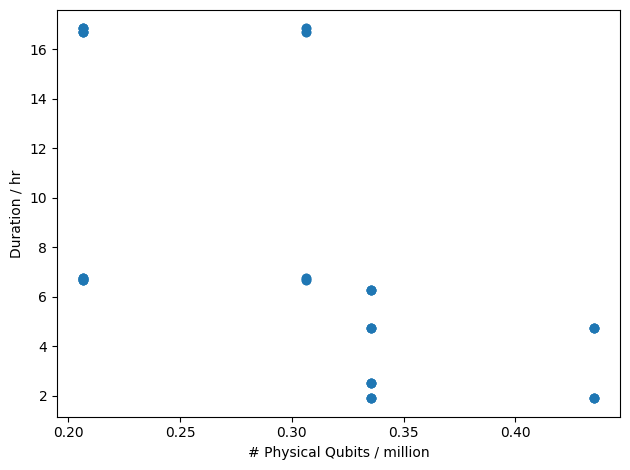

In [11]:
import itertools

duration_hr_estimates = []
n_physical_qubits_estimates = []
for data_block, factory, scheme, phys in itertools.product(data_blocks, factories, schemes, phys_params):
    model = PhysicalCostModel(data_block=data_block, factory=factory, qec_scheme=scheme, physical_params=phys)

    duration_hr_estimates.append(model.duration_hr(alg))
    n_physical_qubits_estimates.append(model.n_phys_qubits(alg))
    

from matplotlib import pyplot as plt
import numpy as np
plt.scatter(np.array(n_physical_qubits_estimates)/1e6, duration_hr_estimates)
plt.xlabel('# Physical Qubits / million')
plt.ylabel('Duration / hr')
plt.tight_layout()